#### In this jupyter notebook, I made 125 clusters for all local business with the convenience score calculated by Izzy as weight
#### And I created coverage area based on the cluster centers I generated

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import geopandas as gpd

In [37]:
# Import dataset that contains convenience score - the weight column (Izzy made the file)
hilo_business = pd.read_csv("../data/hilo_dist_detail.csv")
hilo_business

,Unnamed: 0,Name,Address,Coordinates,Lat,Long,fast_food,user_ratings_total,bakery,cafe,meal_delivery,meal_takeaway,restaurant,food,hours_open,weight
0,0,Hilo Bay Medical Clinic,"24 Pukihae Street, Hilo",POINT (-155.0879458 19.7301366),19.730137,-155.087946,0,1.000000,0,1,0,1,0,0,NaN,6.952381
1,1,Wild Ginger Hotel,"100 Puueo Street, Hilo",POINT (-155.0891752 19.7293163),19.729316,-155.089175,0,0.082481,0,1,0,1,0,0,NaN,7.082481
2,2,Dolphin Bay Hotel,"333 Iliahi Street, Hilo",POINT (-155.0904265 19.7292288),19.729229,-155.090427,0,0.061332,0,1,0,1,0,0,NaN,6.013713
3,3,Hilo Bay Oceanfront Bed and Breakfast,"56 Pukihae Street, Hilo",POINT (-155.0881646 19.7309761),19.730976,-155.088165,0,0.021149,0,1,0,1,0,0,NaN,7.021149
4,4,11 Arruda Ln.,Hilo,POINT (-155.08903 19.728593),19.728593,-155.089030,0,1.000000,0,1,0,1,0,0,NaN,6.952381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,640,College Hall B,Hilo,POINT (-155.0798863 19.7032682),19.703268,-155.079886,0,1.000000,0,1,0,1,0,0,NaN,6.952381
641,641,Kealoha Beach Park,"1701 Kalanianaole Ave Hilo, HI 96720",POINT (-155.033601628064 19.7351520340121),19.735152,-155.033602,0,1.000000,0,1,0,1,0,0,NaN,6.952381
642,642,Liko Lehua Cafe,"177 Kaumana Dr Hilo, HI 96720",POINT (-155.10633 19.71326),19.713260,-155.106330,0,1.000000,0,1,0,1,0,0,NaN,6.952381
643,643,Shell,"394 Kamehameha Avenue, Hilo",POINT (-155.0840452 19.723121),19.723121,-155.084045,0,0.013042,0,1,0,1,0,1,NaN,9.179709


In [38]:
# Clean all rows that do not have a valid coordinate
hilo_business = hilo_business[hilo_business["Coordinates"].notnull()]

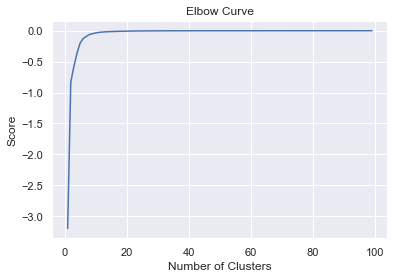

In [39]:
# Create an elbow plot to help us determine k
K_clusters = range(1,100)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = hilo_business[['Lat']]
X_axis = hilo_business[['Long']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the plot, we can see any clusters larger than ~10 will have similar score. Therefore, we can use cluster number larger than 10.
I choose 125 clusters here.

In [40]:
# Perform kmean with 125 clusters with weight (convenience score)
kmeans = KMeans(n_clusters = 125, init ='k-means++')
kmeans.fit(hilo_business[["Lat","Long"]], sample_weight = hilo_business["weight"]) # Compute k-means clustering.
hilo_business['cluster_label'] = kmeans.fit_predict(hilo_business[["Lat","Long"]],sample_weight = hilo_business["weight"])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(hilo_business[["Lat","Long"]],sample_weight = hilo_business["weight"]) # Labels of each point
hilo_business = hilo_business.iloc[:,1:]
hilo_business.head(10)

,Name,Address,Coordinates,Lat,Long,fast_food,user_ratings_total,bakery,cafe,meal_delivery,meal_takeaway,restaurant,food,hours_open,weight,cluster_label
0,Hilo Bay Medical Clinic,"24 Pukihae Street, Hilo",POINT (-155.0879458 19.7301366),19.730137,-155.087946,0,1.000000,0,1,0,1,0,0,NaN,6.952381,81
1,Wild Ginger Hotel,"100 Puueo Street, Hilo",POINT (-155.0891752 19.7293163),19.729316,-155.089175,0,0.082481,0,1,0,1,0,0,NaN,7.082481,116
2,Dolphin Bay Hotel,"333 Iliahi Street, Hilo",POINT (-155.0904265 19.7292288),19.729229,-155.090427,0,0.061332,0,1,0,1,0,0,NaN,6.013713,116
3,Hilo Bay Oceanfront Bed and Breakfast,"56 Pukihae Street, Hilo",POINT (-155.0881646 19.7309761),19.730976,-155.088165,0,0.021149,0,1,0,1,0,0,NaN,7.021149,81
4,11 Arruda Ln.,Hilo,POINT (-155.08903 19.728593),19.728593,-155.089030,0,1.000000,0,1,0,1,0,0,NaN,6.952381,116
5,JUMPSTART PRESCHOOL,"317 Lehua Street, Hilo",POINT (-155.0903387 19.7301202),19.730120,-155.090339,0,1.000000,0,1,0,1,0,0,NaN,6.595238,116
6,Puueo Cluster Head start,"145 Wainaku Street, Hilo",POINT (-155.0913683 19.7283575),19.728358,-155.091368,0,1.000000,0,1,0,1,0,0,NaN,6.952381,116
7,Piihonua 4 Early Childhood,Hilo,POINT (-155.0900154 19.7297152),19.729715,-155.090015,0,1.000000,0,1,0,1,0,0,NaN,6.952381,116
8,Moon and Turtle,"51 Kalakaua Street, Hilo",POINT (-155.0871554 19.7254179),19.725418,-155.087155,0,0.144519,0,1,0,1,1,1,NaN,9.852852,20
9,Cronies Bar & Grill,"11 Waianuenue Avenue, Hilo",POINT (-155.0868843 19.7264366),19.726437,-155.086884,0,0.286218,0,1,0,1,1,1,NaN,10.524313,20


In [41]:
# Transform the business dataset with cluster labels to geodataframe for geojson generating
hilo_business_gdf = gpd.GeoDataFrame(
    hilo_business, geometry=gpd.points_from_xy(hilo_business.Long, hilo_business.Lat, crs='epsg:4326'),crs=4326) 

In [42]:
# Transform the 80 cluster centers to geodataframe for geojson generating
center_df_org = pd.DataFrame(centers, columns = ['lat','long'])
center_gdf_p = gpd.GeoDataFrame(
    center_df_org, geometry=gpd.points_from_xy(center_df_org.long, center_df_org.lat, crs='epsg:4326'),crs=4326) 
# Create a buffer zone. In Hilo, 0.00185° is approximately 1/8 mile, which is 2.5-min walking distance
buffer = center_gdf_p.buffer(0.00185)

C:\Users\Charlie Qiu\AppData\Local\Temp\ipykernel_69644\1810713030.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = center_gdf_p.buffer(0.00185)


In [43]:
# Create geodataframe for 80 buffer zone for geojson generating
center_gdf_buffer = gpd.GeoDataFrame(
    center_gdf_p, geometry=buffer,crs=4326)
center_gdf_buffer

,lat,long,geometry
0,19.717962,-155.113692,"POLYGON ((-155.11184 19.71796, -155.11185 19.7..."
1,19.494006,-154.945293,"POLYGON ((-154.94344 19.49401, -154.94345 19.4..."
2,19.510834,-155.920812,"POLYGON ((-155.91896 19.51083, -155.91897 19.5..."
3,19.721371,-155.065775,"POLYGON ((-155.06392 19.72137, -155.06393 19.7..."
4,19.569130,-155.081895,"POLYGON ((-155.08005 19.56913, -155.08005 19.5..."
...,...,...,...
120,19.564602,-155.088204,"POLYGON ((-155.08635 19.56460, -155.08636 19.5..."
121,19.830720,-155.097192,"POLYGON ((-155.09534 19.83072, -155.09535 19.8..."
122,19.718872,-155.088592,"POLYGON ((-155.08674 19.71887, -155.08675 19.7..."
123,19.694956,-155.075669,"POLYGON ((-155.07382 19.69496, -155.07383 19.6..."


In [44]:
# Extract locations with higher business density
no_outlier_index = hilo_business_gdf[hilo_business_gdf["Lat"]>19.665][hilo_business_gdf["Long"]>-155.15][hilo_business_gdf["Long"]<-155.02][hilo_business_gdf["Lat"]<19.75].cluster_label.unique()

d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [45]:
# Extract on locations with higher business density
recluster = hilo_business_gdf[hilo_business_gdf["Lat"]>19.665][hilo_business_gdf["Long"]>-155.15][hilo_business_gdf["Long"]<-155.02][hilo_business_gdf["Lat"]<19.75]

d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


<AxesSubplot:>

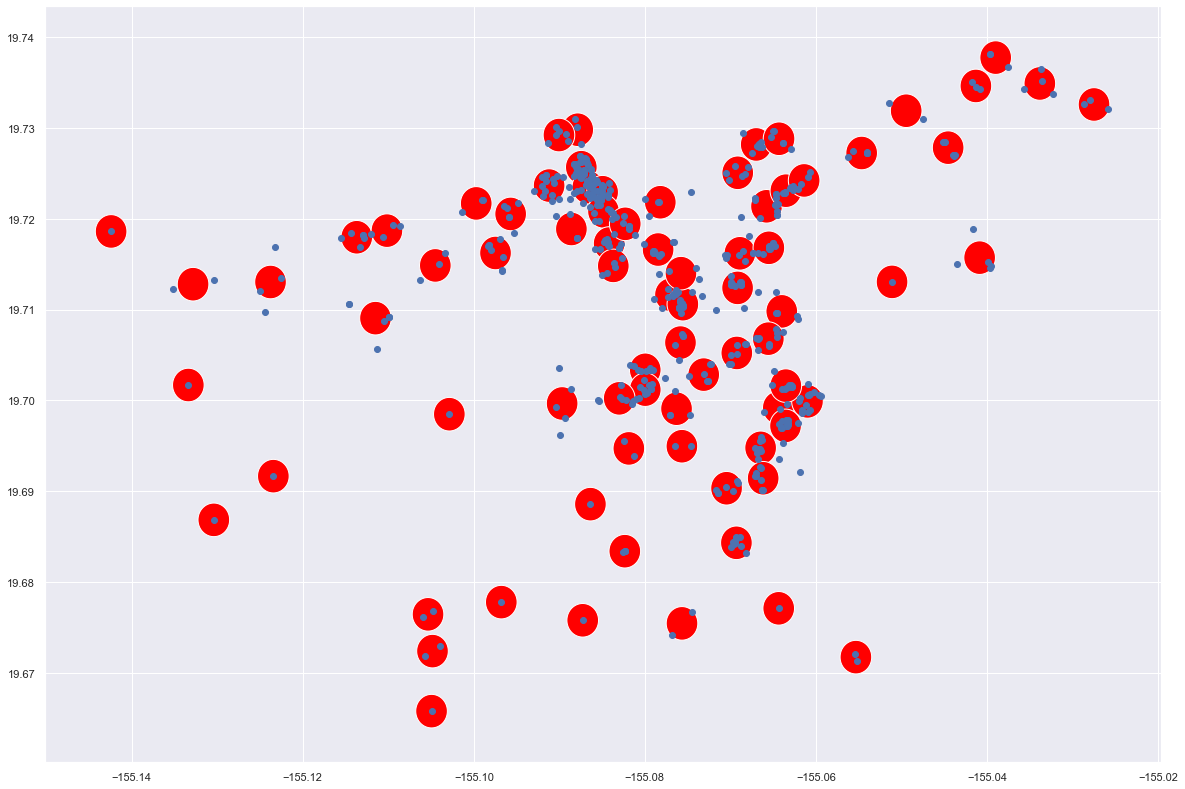

In [46]:
# Plot the region with high business density to see if it is needed to recluster
fig, ax = plt.subplots(figsize=(20, 20))
buffer[no_outlier_index].plot(ax=ax,figsize=(20,20),color="red")
recluster.plot(ax=ax,figsize=(20,20))

Since these regions have high business density, we need to ensure that these regions have good distribution point coverage. Therefore, I decide
to perform a k-mean again for this region

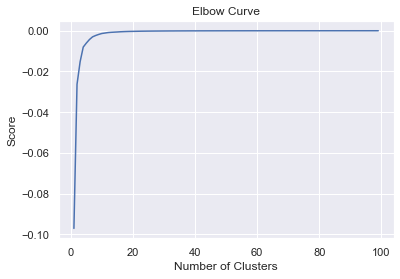

In [47]:
# Recluster, only clustering regions with high business density
# I first create the elbow plot to determine k
K_clusters = range(1,100)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = recluster[['Lat']]
X_axis = recluster[['Long']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the plot, we can see any clusters larger than ~10 will have similar score. Therefore, we can use cluster number larger than 10.

In [48]:
buffer[no_outlier_index].shape

(78,)

The regions that need to be reclustered have 78 clusters, so when performing the recluster algorithm, I will use n_clusters = 78 so that
I will have 125 clusters at last

In [49]:
# Reperform k-mean with 40 clusters in the high-business-density region
kmeans_2 = KMeans(n_clusters = 78, init ='k-means++')
kmeans_2.fit(recluster[["Lat","Long"]], sample_weight = recluster["weight"]) # Compute k-means clustering.
recluster['cluster_label'] = kmeans_2.fit_predict(recluster[["Lat","Long"]], sample_weight = recluster["weight"])
centers_re = kmeans_2.cluster_centers_ # Coordinates of cluster centers.
labels_2 = kmeans_2.predict(recluster[["Lat","Long"]], sample_weight = recluster["weight"]) # Labels of each point
centers_re

array([[  19.71679613, -155.06598233],
       [  19.72203988, -155.08861889],
       [  19.69736329, -155.06370062],
       [  19.71802188, -155.11343727],
       [  19.73774112, -155.03897532],
       [  19.70051561, -155.0841054 ],
       [  19.71099979, -155.07639869],
       [  19.6777939 , -155.0967874 ],
       [  19.7318923 , -155.04944106],
       [  19.68432544, -155.06929414],
       [  19.72818026, -155.06697664],
       [  19.68685137, -155.13040519],
       [  19.72053116, -155.09569503],
       [  19.71279505, -155.13283155],
       [  19.70894059, -155.06413448],
       [  19.71813967, -155.08314408],
       [  19.70846134, -155.11028987],
       [  19.68340092, -155.082345  ],
       [  19.71571785, -155.04085231],
       [  19.70308766, -155.07247673],
       [  19.69136728, -155.0665355 ],
       [  19.6744248 , -155.10509465],
       [  19.67173805, -155.0553217 ],
       [  19.71095902, -155.0685308 ],
       [  19.72181796, -155.07819448],
       [  19.72363685, -1

In [50]:
# Create buffer zone for the newly genereated 40 clusters
center_df_re = pd.DataFrame(centers_re, columns = ['lat','long'])
center_df_gdf = gpd.GeoDataFrame(center_df_re, geometry = gpd.points_from_xy(center_df_re.long, center_df_re.lat, crs='epsg:4326'))
buffer_re = center_df_gdf.buffer(0.00185)

C:\Users\Charlie Qiu\AppData\Local\Temp\ipykernel_69644\1849408693.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer_re = center_df_gdf.buffer(0.00185)


<AxesSubplot:>

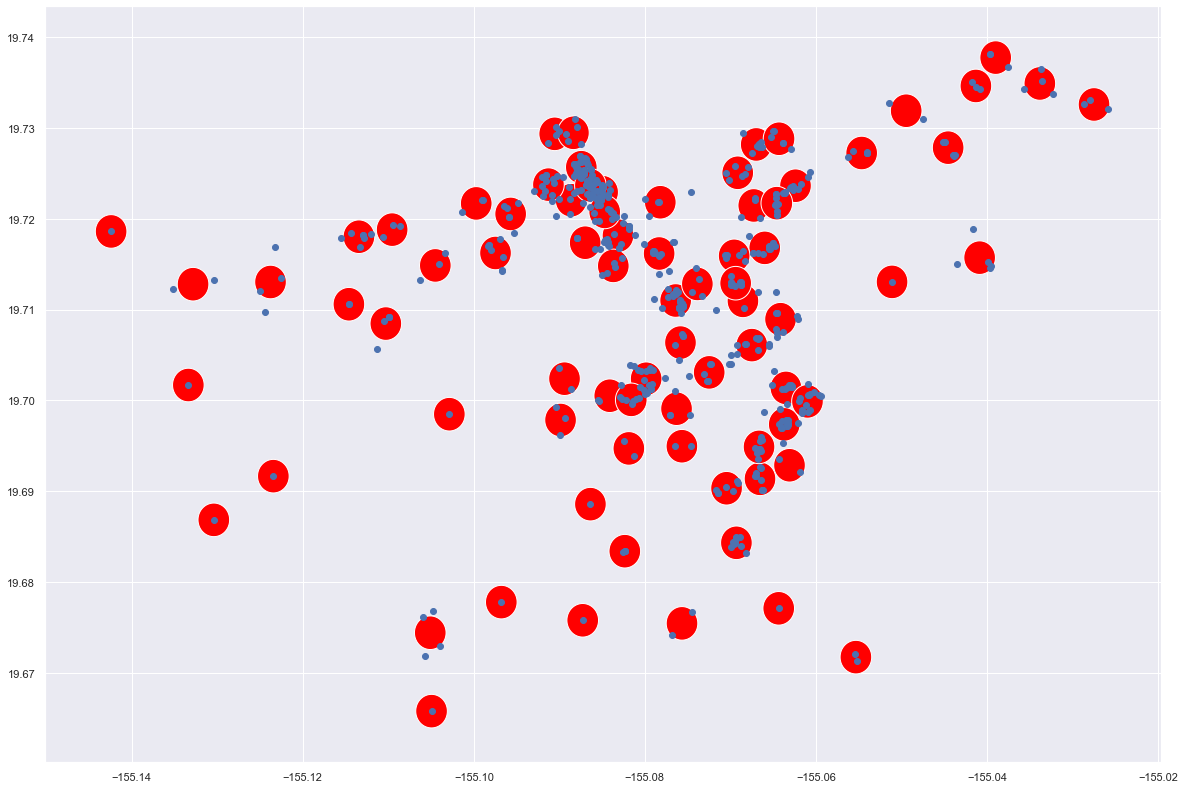

In [51]:
# Visualize the reclustering results
center_gdf_re = gpd.GeoDataFrame(
    center_df_re, geometry=buffer_re,crs=4326) 
fig, ax = plt.subplots(figsize=(20, 20))
center_gdf_re.plot(ax=ax,color="red")
recluster.plot(ax=ax)

In [52]:
# Replace the old 40 cluster centers in the high-business-density region with new 40 centers generated in reclusetering
final_gal = pd.concat([center_gdf_re,center_gdf_buffer.drop(no_outlier_index)])
final_gal

,lat,long,geometry
0,19.716796,-155.065982,"POLYGON ((-155.06413 19.71680, -155.06414 19.7..."
1,19.722040,-155.088619,"POLYGON ((-155.08677 19.72204, -155.08678 19.7..."
2,19.697363,-155.063701,"POLYGON ((-155.06185 19.69736, -155.06186 19.6..."
3,19.718022,-155.113437,"POLYGON ((-155.11159 19.71802, -155.11160 19.7..."
4,19.737741,-155.038975,"POLYGON ((-155.03713 19.73774, -155.03713 19.7..."
...,...,...,...
97,19.495262,-154.948956,"POLYGON ((-154.94711 19.49526, -154.94711 19.4..."
103,19.849182,-155.145893,"POLYGON ((-155.14404 19.84918, -155.14405 19.8..."
109,19.505658,-154.957824,"POLYGON ((-154.95597 19.50566, -154.95598 19.5..."
120,19.564602,-155.088204,"POLYGON ((-155.08635 19.56460, -155.08636 19.5..."


In [53]:
# Create the geodataframe for the cluster centroid of our newest 80 clusters
final_gal_centroid = gpd.GeoDataFrame(final_gal, geometry = gpd.points_from_xy(final_gal.long, final_gal.lat))
final_gal_centroid

,lat,long,geometry
0,19.716796,-155.065982,POINT (-155.06598 19.71680)
1,19.722040,-155.088619,POINT (-155.08862 19.72204)
2,19.697363,-155.063701,POINT (-155.06370 19.69736)
3,19.718022,-155.113437,POINT (-155.11344 19.71802)
4,19.737741,-155.038975,POINT (-155.03898 19.73774)
...,...,...,...
97,19.495262,-154.948956,POINT (-154.94896 19.49526)
103,19.849182,-155.145893,POINT (-155.14589 19.84918)
109,19.505658,-154.957824,POINT (-154.95782 19.50566)
120,19.564602,-155.088204,POINT (-155.08820 19.56460)


In [54]:
# Create the geodataframe for the cluster buffer zone (coverage area) of our newest 80 clusters
final_gal = pd.concat([center_gdf_re,center_gdf_buffer.drop(no_outlier_index)])
final_gal_gdf = gpd.GeoDataFrame(
    final_gal, geometry=final_gal.geometry,crs=4326)
final_gal_gdf

,lat,long,geometry
0,19.716796,-155.065982,"POLYGON ((-155.06413 19.71680, -155.06414 19.7..."
1,19.722040,-155.088619,"POLYGON ((-155.08677 19.72204, -155.08678 19.7..."
2,19.697363,-155.063701,"POLYGON ((-155.06185 19.69736, -155.06186 19.6..."
3,19.718022,-155.113437,"POLYGON ((-155.11159 19.71802, -155.11160 19.7..."
4,19.737741,-155.038975,"POLYGON ((-155.03713 19.73774, -155.03713 19.7..."
...,...,...,...
97,19.495262,-154.948956,"POLYGON ((-154.94711 19.49526, -154.94711 19.4..."
103,19.849182,-155.145893,"POLYGON ((-155.14404 19.84918, -155.14405 19.8..."
109,19.505658,-154.957824,"POLYGON ((-154.95597 19.50566, -154.95598 19.5..."
120,19.564602,-155.088204,"POLYGON ((-155.08635 19.56460, -155.08636 19.5..."


In [55]:
# Get the columns we want for the business dataset
hilo_business_gdf = hilo_business_gdf.loc[:,["Name","Address","Coordinates","Lat","Long","cluster_label","weight","geometry"]]

In [62]:
# Get the geojson of cluster buffer zone
final_gal_gdf.to_file("hilo_distribution_buffer_125.geojson",driver="GeoJSON")

In [63]:
# Get the geojson of Hilo's local business
hilo_business_gdf.to_file("hilo_local_business_125.geojson", driver="GeoJSON")  

In [61]:
# Get the geojson of Hilo's cluster centroid
final_gal_centroid.to_file("hilo_distribution_centroid_125.geojson", driver="GeoJSON")

####  I use QGIS and ArcGIS to finish mapping, the links are in the README file